# ***Projeto Oraculum***: Análise de Viabilidade de Terreno

Este notebook contém o fluxo de análise do projeto Oraculum. O objetivo é processar imagens de satélite e de relevo para gerar um score de viabilidade para construção civil.

## 1. Configuração do Ambiente

 1. Abra o Terminal (ALT + F12 no PyCharm) e execute '***pip install -r requirements.txt***'
 2. Inicie a autenticação com o projeto no Google Cloud

> (Caso o terminal dê errado, execute a célula abaixo)

In [1]:
'''Caso dê errado ou preguiça:'''
#Instalação de dependências
!pip install numpy opencv-python matplotlib tifffile imagecodecs rasterio earthengine-api geemap

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import time
from datetime import datetime
import re

# Biblioteca principal para interagir com o Google Earth Engine
import ee
import geemap

# Bibliotecas especializadas para arquivos GeoTIFF
import tifffile
import rasterio
from rasterio.warp import reproject, Resampling

#Nossas próprias bibliotecas
import processamento
import utilitarios
import obter_dados

In [2]:
ID_PROJETO_GOOGLE = 'oraculum-eseg'
obter_dados.autenticar_ee(ID_PROJETO_GOOGLE)

>>> Conexão com Google Earth Engine estabelecida com sucesso!


## 2. Definição da Área e Aquisição de Dados

Aqui definimos o ponto central e o tamanho da área que desejamos analisar. As funções do módulo `utilitarios` convertem as coordenadas para o formato correto e criam um polígono da área de interesse (AOI). Em seguida, o módulo `obter_dados` utiliza essa AOI para baixar os dados de satélite e relevo do Google Earth Engine.

In [3]:
# --- 1. DEFINA O LOCAL E TAMANHO ---
lat_dms = "20°14'58.2\"S"
lon_dms = "46°59'53.7\"W"
tamanho_km = 10

# --- 2. CONVERTER E CRIAR A ÁREA ---
lat_dd = utilitarios.dms_para_dd(lat_dms)
lon_dd = utilitarios.dms_para_dd(lon_dms)
coords_poligono = utilitarios.criar_bounding_box(lat_dd, lon_dd, tamanho_km)
area_de_interesse = ee.Geometry.Polygon(coords_poligono)

# --- 3. DEFINIR PASTA DE SAÍDA E BAIXAR OS DADOS ---
# A função agora retorna o caminho da pasta onde os arquivos foram salvos.
caminho_arquivo_satelite, caminho_arquivo_relevo = obter_dados.baixar_dados_da_area(
    area_de_interesse,
    pasta_mae="outputs"
)

print(f"\nArquivos para esta análise:")
print(f"Satélite: {caminho_arquivo_satelite}")
print(f"Relevo: {caminho_arquivo_relevo}")

Sessão de análise iniciada. Arquivos serão salvos em: 'outputs\20250905_174724'

--- ETAPA 1: Imagem de Satélite ---
Exportando para o Google Drive... (Status: READY, Tempo: 0s)
Exportando para o Google Drive... (Status: RUNNING, Tempo: 30s)
Exportando para o Google Drive... (Status: COMPLETED, Tempo: 61s)

[SUCESSO] Imagem de satélite exportada para o Google Drive!
>>> AÇÃO NECESSÁRIA: Baixe o arquivo e coloque na pasta do projeto. <<<

--- ETAPA 2: Imagem de Relevo ---
Generating URL ...
Please wait ...
Data downloaded to C:\Users\fabri\PycharmProjects\Oraculum\outputs\20250905_174724\20250905_174724_relevo.tif
[SUCESSO] Arquivo de relevo baixado diretamente.

Arquivos para esta análise:
Satélite: outputs\20250905_174724\20250905_174724_satelite.tif
Relevo: outputs\20250905_174724\20250905_174724_relevo.tif


In [4]:
# --- CONFIGURAÇÃO DA ANÁLISE ---
# Para analisar um conjunto de dados, cole o timestamp da pasta aqui.
# Se você acabou de baixar, use o timestamp que apareceu na saída da célula anterior.
# Se quer analisar dados antigos, copie o nome da pasta de 'outputs'.

timestamp_da_analise = "20250905_174724" # ⇽ ÚNICO LUGAR PARA MUDAR

# --- Construção automática dos caminhos ---
pasta_da_sessao = os.path.join("outputs", timestamp_da_analise)
caminho_arquivo_satelite = os.path.join(pasta_da_sessao, f"{timestamp_da_analise}_satelite.tif")
caminho_arquivo_relevo = os.path.join(pasta_da_sessao, f"{timestamp_da_analise}_relevo.tif")

print(f"Pronto para analisar a sessão: {timestamp_da_analise}")
print(f"Verificando se os arquivos existem...")

# Checagem de segurança
if os.path.exists(caminho_arquivo_satelite) and os.path.exists(caminho_arquivo_relevo):
    print(">>> SUCESSO! Arquivos encontrados. Pode prosseguir com as próximas células de análise.")
else:
    print(">>> ERRO! Um ou ambos os arquivos não foram encontrados. Verifique o timestamp ou se você baixou o arquivo do Google Drive.")

Pronto para analisar a sessão: 20250905_174724
Verificando se os arquivos existem...
>>> SUCESSO! Arquivos encontrados. Pode prosseguir com as próximas células de análise.


## 3. Processamento Inicial de Imagens

Reprojeção concluída!
Processamento finalizado.

Dados finais e PERFEITAMENTE ALINHADOS armazenados em memória.
Salvando os arquivos de DADOS alinhados para uso futuro...
Arquivo de satélite (visual) salvo em: outputs\20250905_174724\satelite_alinhado.png
Arquivo de relevo (dados) salvo em: outputs\20250905_174724\relevo_alinhado.tif
Gerando e salvando os GRÁFICOS de visualização...
Imagem visual SÓ do relevo salva em: outputs\20250905_174724\relevo_alinhado_visual.png
Gráfico de comparação salvo em: outputs\20250905_174724\comparacao_alinhamento.png


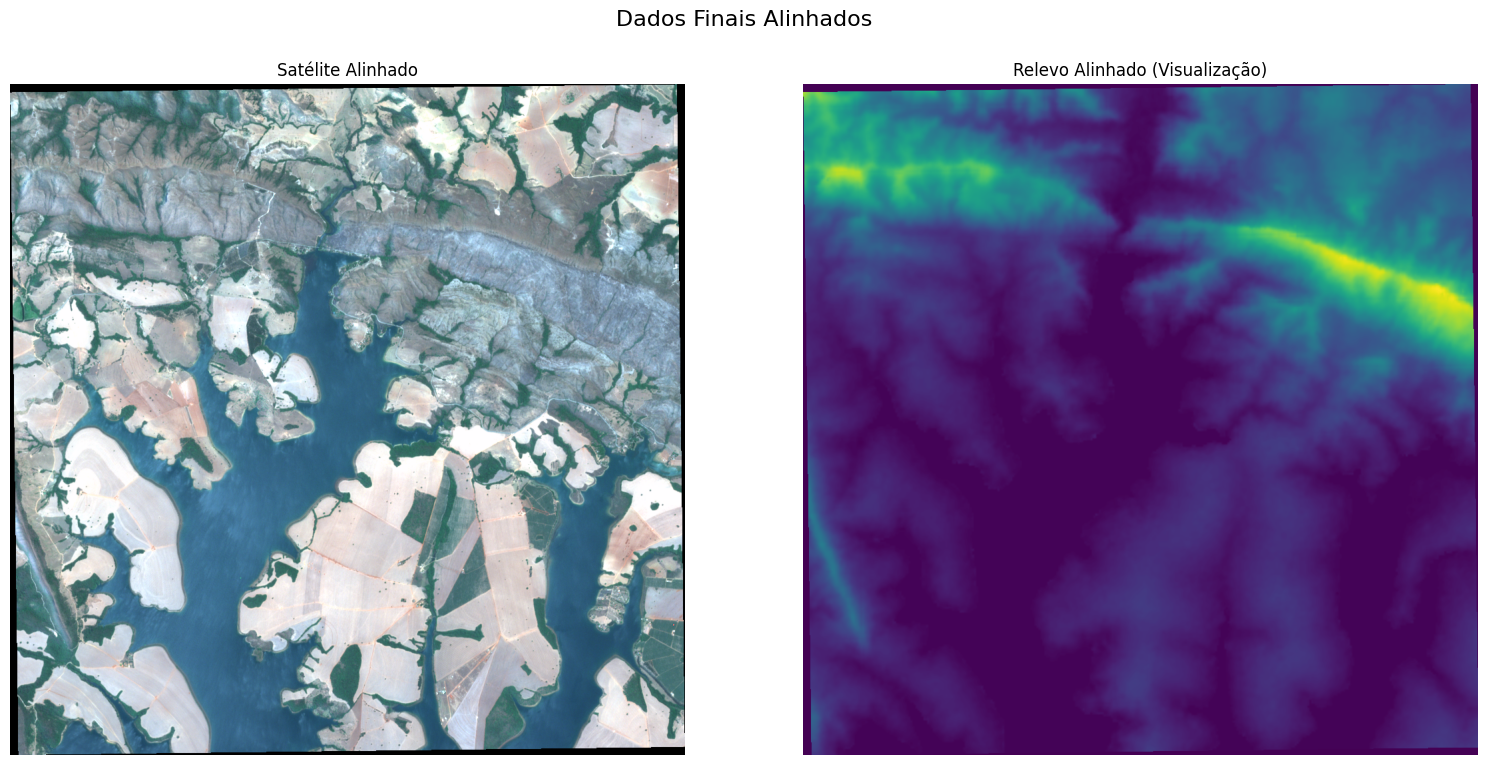

In [11]:
# --- Célula de Carga e Alinhamento de Imagens ---

# Esta célula usa as variáveis 'caminho_arquivo_satelite' e 'caminho_arquivo_relevo' que foram criadas na célula de configuração.
# A função retorna as 2 imagens FINAIS e ALINHADAS, e também o valor nodata do relevo
IMG_SATELITE, IMG_RELEVO, nodata_relevo = processamento.alinhar_imagens(
    caminho_arquivo_satelite,
    caminho_arquivo_relevo
)
print("\nDados finais e PERFEITAMENTE ALINHADOS armazenados em memória.")

print("Salvando os arquivos de DADOS alinhados para uso futuro...")
caminho_saida_satelite_png = os.path.join(pasta_da_sessao, 'satelite_alinhado.png')
caminho_saida_relevo_tif = os.path.join(pasta_da_sessao, 'relevo_alinhado.tif')

plt.imsave(caminho_saida_satelite_png, IMG_SATELITE)
tifffile.imwrite(caminho_saida_relevo_tif, IMG_RELEVO)

print(f"Arquivo de satélite (visual) salvo em: {caminho_saida_satelite_png}")
print(f"Arquivo de relevo (dados) salvo em: {caminho_saida_relevo_tif}")

print("Gerando e salvando os GRÁFICOS de visualização...")
# Prepara os dados do relevo para a visualização com contraste correto
dados_validos_relevo = IMG_RELEVO != nodata_relevo
min_relevo = IMG_RELEVO[dados_validos_relevo].min()
max_relevo = IMG_RELEVO[dados_validos_relevo].max()

# --- SALVA A IMAGEM SÓ DO RELEVO COLORIDO ---
caminho_saida_relevo_visual = os.path.join(pasta_da_sessao, 'relevo_alinhado_visual.png')
plt.imsave(
    caminho_saida_relevo_visual,
    IMG_RELEVO,
    cmap='viridis',
    vmin=min_relevo,
    vmax=max_relevo
)
print(f"Imagem visual SÓ do relevo salva em: {caminho_saida_relevo_visual}")

# Cria a figura de COMPARAÇÃO para exibir no notebook e salvar
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Dados Finais Alinhados', fontsize=16)
ax[0].imshow(IMG_SATELITE)
ax[0].set_title(f'Satélite Alinhado')
ax[0].axis('off')
ax[1].imshow(IMG_RELEVO, cmap='viridis', vmin=min_relevo, vmax=max_relevo)
ax[1].set_title(f'Relevo Alinhado (Visualização)')
ax[1].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Salva a FIGURA COMPLETA de comparação
caminho_saida_grafico = os.path.join(pasta_da_sessao, 'comparacao_alinhamento.png')
plt.savefig(caminho_saida_grafico, dpi=300, bbox_inches='tight')
print(f"Gráfico de comparação salvo em: {caminho_saida_grafico}")

# Mostra o gráfico de comparação no notebook
plt.show()

Gerando e salvando a visualização 3D (v1)...
Criando visualização 3D (fusão de satélite e relevo)...
Visualização 3D criada com sucesso.
Imagem da visualização V1 salva em: outputs\20250905_174724\visualizacao_3D_v1.png


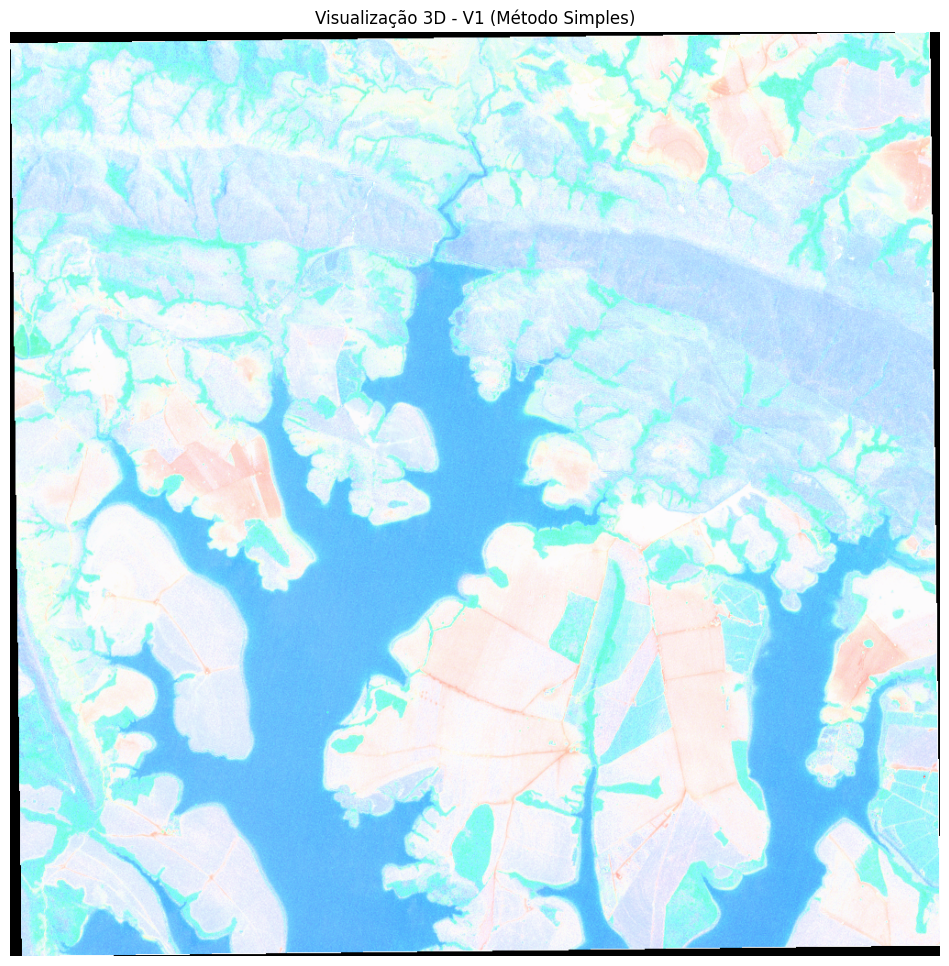

In [16]:
# --- Célula de Teste e Salvamento da Visualização V1 (Obsoleta) ---

print("Gerando e salvando a visualização 3D (v1)...")

# Chama a função v1 (obsoleta) que mantivemos para registro histórico
vis_v1 = processamento.fundir_imagens_v1(IMG_SATELITE, IMG_RELEVO)

# --- Exibir e Salvar ---
plt.figure(figsize=(12, 12))
plt.imshow(vis_v1)
plt.title('Visualização 3D - V1 (Método Simples)')
plt.axis('off')

# Constrói o caminho de saída DENTRO da pasta da sessão
# A variável 'pasta_da_sessao' foi criada na célula de aquisição de dados
nome_arquivo_saida = os.path.join(pasta_da_sessao, 'visualizacao_3D_v1.png')

# Salva a figura em alta qualidade
plt.savefig(nome_arquivo_saida, dpi=300, bbox_inches='tight', pad_inches=0.1)

print(f"Imagem da visualização V1 salva em: {nome_arquivo_saida}")

# Mostra a figura no notebook
plt.show()

--- Testando e salvando a função de visualização 3D definitiva (Hillshade) ---
Criando visualização 3D final (Método de Modulação HSV)...
Visualização 3D criada com sucesso.
Imagem da visualização V2 (Hillshade + HSV) salva em: outputs\20250905_174724\visualizacao_3D_v2.png


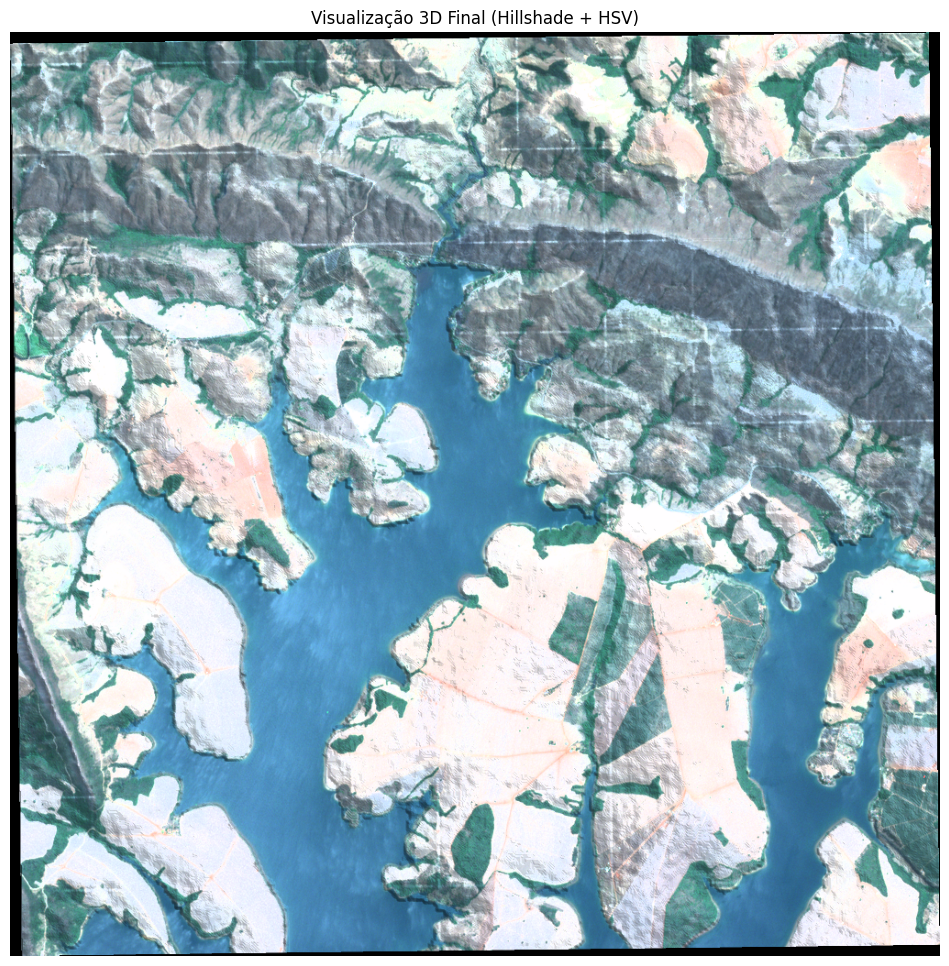

In [19]:
# --- Célula de Teste e Salvamento da Visualização V2 (Hillshade) ---

print("--- Testando e salvando a função de visualização 3D definitiva (Hillshade) ---")

# Chama a nova função final que usa Hillshade
imagem_3d_final = processamento.fundir_imagens_v2_3D(IMG_SATELITE, IMG_RELEVO)

# --- Exibir e Salvar ---
plt.figure(figsize=(12, 12))
plt.imshow(imagem_3d_final)
plt.title('Visualização 3D Final (Hillshade + HSV)')
plt.axis('off')

# Constrói o caminho de saída DENTRO da pasta da sessão
# A variável 'pasta_da_sessao' foi criada na célula de aquisição de dados
nome_arquivo_saida = os.path.join(pasta_da_sessao, 'visualizacao_3D_v2.png')

# Salva a figura em alta qualidade
plt.savefig(nome_arquivo_saida, dpi=300, bbox_inches='tight', pad_inches=0.1)

print(f"Imagem da visualização V2 (Hillshade + HSV) salva em: {nome_arquivo_saida}")

# Mostra a figura no notebook
plt.show()

## Área de Teste